<a href="https://colab.research.google.com/github/achalgarg14/session_4/blob/main/Session_4_Assignment_Code_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Attempt 1:
##Target:

* Get the set-up right
* Set Transforms (with Image Normalization)
* Set Data Loader
* Set Basic Working Code
* Set Basic Training & Test Loop
* Set plotting of Train and Test Accuracy and Loss Graphs 

##Results:

* Total Parameters: 140,688
* Best Training Accuracy: 99.59%
* Best Test Accuracy: 98.77%

##Analysis:

* Model is overfitting. It can be inferred from training accuracy that it has nearly learnt (what it can) but test accuracy is still low.
* In nearly all epochs (post first 3 epochs) training accuracy is more than testing accuracy. Model has started remembering training data and is resulting in lower test accuracy.
* Parameters in this model need to be reduced and regularized to make the model learn better.

# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [14]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Dataset and Creating Train/Test Split

In [15]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [16]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


#Data Checking

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train Data Stats]
Numpy Shape: (60000, 28, 28)
Tensor Shape: torch.Size([60000, 28, 28])
min: tensor(-0.4242)
max: tensor(2.8215)
mean: tensor(-0.0001)
std: tensor(1.0000)
var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])
tensor(4)


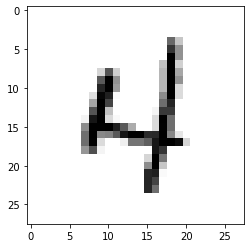

In [17]:
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train Data Stats]')
print('Numpy Shape:', train.train_data.cpu().numpy().shape)
print('Tensor Shape:', train.train_data.size())
print('min:', torch.min(train_data))
print('max:', torch.max(train_data))
print('mean:', torch.mean(train_data))
print('std:', torch.std(train_data))
print('var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt
print(labels[0])
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

##Looking at bigger dataset
To understand data further for augmentation

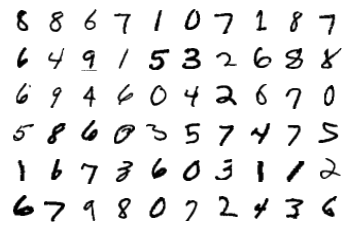

In [18]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Basic model to check everything is working

In [21]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
        ) # output_size = 26  RF = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
        ) # output_size = 24  RF = 5

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 24  RF = 7
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11  RF = 8

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
        ) # output_size = 9  RF = 12
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
        ) # output_size = 7  RF = 16
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
        ) # output_size = 5  RF = 20
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
        ) # output_size = 3  RF = 24
        
        # OUTPUT BLOCK

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
        ) # output_size = 1  RF = 28


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [22]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
            Conv2d-3           [-1, 32, 24, 24]           4,608
              ReLU-4           [-1, 32, 24, 24]               0
            Conv2d-5           [-1, 64, 22, 22]          18,432
              ReLU-6           [-1, 64, 22, 22]               0
         MaxPool2d-7           [-1, 64, 11, 11]               0
            Conv2d-8             [-1, 16, 9, 9]           9,216
              ReLU-9             [-1, 16, 9, 9]               0
           Conv2d-10             [-1, 32, 7, 7]           4,608
             ReLU-11             [-1, 32, 7, 7]               0
           Conv2d-12             [-1, 64, 5, 5]          18,432

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [23]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

#Training and Testing of our model

In [24]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch + 1)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 1


Loss=0.125138059258461 Batch_id=468 Accuracy=70.34: 100%|██████████| 469/469 [00:21<00:00, 22.24it/s]



Test set: Average loss: 0.1307, Accuracy: 9587/10000 (95.87%)

EPOCH: 2


Loss=0.13742758333683014 Batch_id=468 Accuracy=96.88: 100%|██████████| 469/469 [00:15<00:00, 31.23it/s]



Test set: Average loss: 0.0743, Accuracy: 9766/10000 (97.66%)

EPOCH: 3


Loss=0.037332482635974884 Batch_id=468 Accuracy=98.04: 100%|██████████| 469/469 [00:14<00:00, 31.91it/s]



Test set: Average loss: 0.0598, Accuracy: 9810/10000 (98.10%)

EPOCH: 4


Loss=0.09602690488100052 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:14<00:00, 32.60it/s]



Test set: Average loss: 0.0635, Accuracy: 9804/10000 (98.04%)

EPOCH: 5


Loss=0.01639939285814762 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:14<00:00, 32.66it/s]



Test set: Average loss: 0.0485, Accuracy: 9860/10000 (98.60%)

EPOCH: 6


Loss=0.007844328880310059 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:18<00:00, 25.92it/s]



Test set: Average loss: 0.0527, Accuracy: 9847/10000 (98.47%)

EPOCH: 7


Loss=0.020830774679780006 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:14<00:00, 31.96it/s]



Test set: Average loss: 0.0485, Accuracy: 9851/10000 (98.51%)

EPOCH: 8


Loss=0.06025564670562744 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:14<00:00, 32.27it/s]



Test set: Average loss: 0.0455, Accuracy: 9870/10000 (98.70%)

EPOCH: 9


Loss=0.0028186815325170755 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:14<00:00, 31.91it/s]



Test set: Average loss: 0.0478, Accuracy: 9853/10000 (98.53%)

EPOCH: 10


Loss=0.009412701241672039 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:14<00:00, 32.37it/s]



Test set: Average loss: 0.0464, Accuracy: 9877/10000 (98.77%)

EPOCH: 11


Loss=0.008395160548388958 Batch_id=468 Accuracy=99.57: 100%|██████████| 469/469 [00:14<00:00, 32.23it/s]



Test set: Average loss: 0.0469, Accuracy: 9866/10000 (98.66%)

EPOCH: 12


Loss=0.006062633823603392 Batch_id=468 Accuracy=99.59: 100%|██████████| 469/469 [00:14<00:00, 31.84it/s]



Test set: Average loss: 0.0574, Accuracy: 9846/10000 (98.46%)

EPOCH: 13


Loss=0.022231535986065865 Batch_id=468 Accuracy=99.66: 100%|██████████| 469/469 [00:14<00:00, 32.00it/s]



Test set: Average loss: 0.0534, Accuracy: 9861/10000 (98.61%)

EPOCH: 14


Loss=0.019720720127224922 Batch_id=468 Accuracy=99.65: 100%|██████████| 469/469 [00:14<00:00, 32.43it/s]



Test set: Average loss: 0.0573, Accuracy: 9857/10000 (98.57%)

EPOCH: 15


Loss=0.025136394426226616 Batch_id=468 Accuracy=99.71: 100%|██████████| 469/469 [00:14<00:00, 32.58it/s]



Test set: Average loss: 0.0505, Accuracy: 9870/10000 (98.70%)



# Plotting Accuracy and Loss Graphs



In [25]:
train_losses1 = [t.cpu().item() for t in train_losses]

Text(0.5, 1.0, 'Test Accuracy')

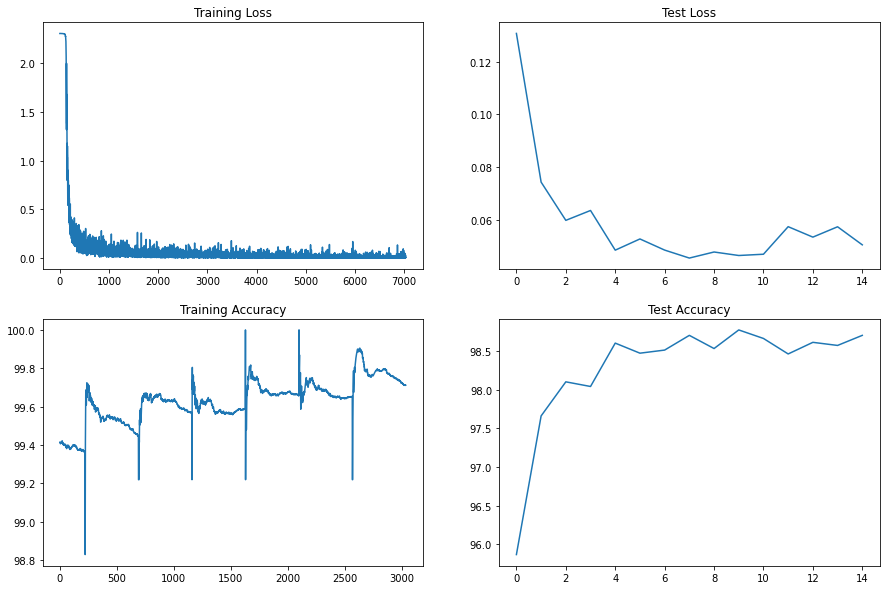

In [26]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses1)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")